In [1]:
!pip install -U seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.6/site-packages (0.11.2)


# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

#Azdias EDA
print(azdias.shape) #891K rows, 85 columns
display(azdias.head()) #First few rows

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
#There are definitely missing/null info which needs handling from the start.
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [6]:
azdias.describe() #nothing of note here, although there are -1 involved which would need re-encoding or np.nan.

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info_gb = feat_info.groupby('type').attribute.count()
feat_info_gb.sort_values(ascending=False)
#49 ordinal variables, 21 categorical variables

type
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: attribute, dtype: int64

In [8]:
feat_info #displays the information about the features. Particularly, the last column shows the missing or unknown
#labels which must be relabelled to np.nan.

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
print(len(azdias.loc[azdias.isna().any(1)]), ',', len(azdias.loc[azdias.isna().any(1)])/azdias.shape[0]) 
#There are 628K of rows in the demographic dataset with null values, amounting to about 70% of the dataset (prior to conversion)

628074 , 0.7047342914944777


In [10]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [11]:
#Transform feat_info dataframe first
features = feat_info.T
features.columns = features.iloc[0]
features = features[1:]
features

attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
information_level,person,person,person,person,person,person,person,person,person,person,...,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,macrocell_plz8,community,community,community
type,categorical,ordinal,categorical,categorical,ordinal,ordinal,ordinal,ordinal,ordinal,ordinal,...,ordinal,ordinal,ordinal,ordinal,mixed,ordinal,ordinal,ordinal,ordinal,ordinal
missing_or_unknown,"[-1,0]","[-1,0,9]","[-1,0]",[0],[-1],[-1],[-1],[-1],[-1],[-1],...,[-1],[-1],[-1],[-1],"[-1,0]",[-1],[-1],"[-1,9]","[-1,0]","[-1,9]"


In [12]:
#2 sets of data columns are identical with no missing/additional columns
for col in azdias.columns:
    if col not in features.columns:
        print(col)

In [13]:
#2 sets of data columns are identical with no missing/additional columns
for col in features.columns:
    if col not in azdias.columns:
        print(col)

In [14]:
#Make a copy so as not to disrupt original data
azdias_copy = azdias.copy()

#Newly encode the azdias dataset with missing or unknown values by NIL 
for col in azdias_copy.columns:
    try:
        encoded_vals = json.loads(features[col].missing_or_unknown)
    except:
        continue
    azdias_copy[col] = azdias_copy[col].apply(lambda x: 'NIL' if x in encoded_vals else x)

In [15]:
#count of NIL data per column
nil_data_col = azdias_copy.isin(['NIL']).sum(axis=0)
nil_data_col_df = pd.DataFrame(nil_data_col)
nil_data_col_df = nil_data_col_df.rename(columns={0:'count_nils'})

In [16]:
nil_data_col_df['percentage'] = nil_data_col_df.count_nils / azdias_copy.shape[0]

In [17]:
# pd.options.display.max_rows = 99
nil_data_col_df.sort_values(by=['percentage'], inplace=True, ascending=False)
display(nil_data_col_df)
#From the results below, we can see that top 5 columns have missing/unknown original encodings from 27% to 92%.
#Especially for column TITEL_KZ and AGER_TYP, which are category for academic title and elderly.
#High NILs for Academic title makes sense since majority might not have the title of Prof or Dr and hence not applicable. Perhaps 0 rather than np.nan?
#High NILs for Elderly makes sense as majority might not be seniors/elderly. Perhaps 0 rather than np.nan?


,count_nils,percentage
TITEL_KZ,815562,0.915106
AGER_TYP,685843,0.769554
GEBURTSJAHR,392318,0.440203
KBA05_BAUMAX,343200,0.385090
ALTER_HH,236768,0.265667
HEALTH_TYP,111196,0.124768
SHOPPER_TYP,111196,0.124768
VERS_TYP,111196,0.124768
NATIONALITAET_KZ,108315,0.121536
PRAEGENDE_JUGENDJAHRE,108164,0.121366


In [18]:
#count of NIL data by row
nil_data_row = (azdias_copy == 'NIL').any(axis=1).sum()
print(nil_data_row, ',', nil_data_row / azdias_copy.shape[0])
#Almost 100% of the data had at least 1 missing/unknown original value.

890934 , 0.9996779698862571


In [19]:
#Replace NILs with np.nan
azdias_copy = azdias_copy.replace('NIL', np.nan)

In [20]:
azdias_copy.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [21]:
# Perform an assessment of how much missing data there is in each column of the dataset.

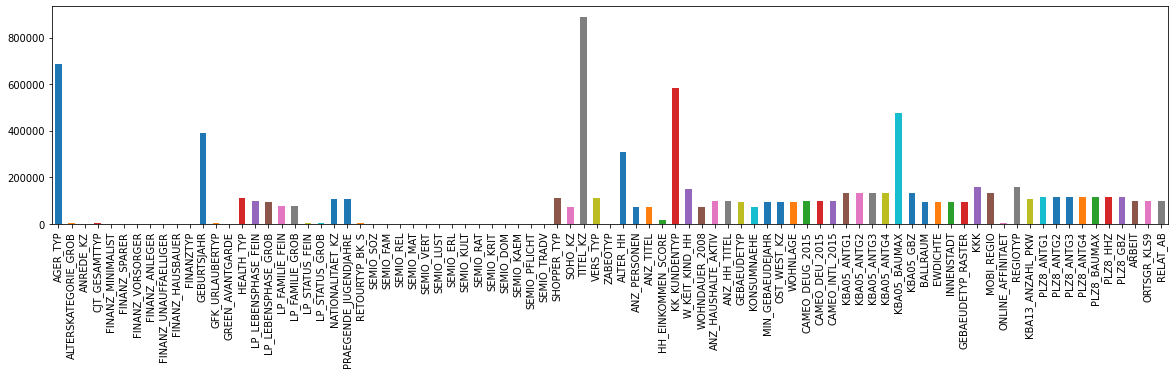

In [22]:
plt.figure(figsize=(20,4))
vc_nulls = azdias_copy.apply(lambda x: x.isnull().value_counts()).T[True]
vc_nulls.plot(kind = 'bar')
plt.show()
#Plot shows few features with extremely high no. of missing values (TITEL_KZ, AGER_TYP, KK_KUNDENTYP, GEBURTSJAHR)

In [23]:
#Chart by proportion
vc_nulls_prop = pd.DataFrame(vc_nulls)
vc_nulls_prop = vc_nulls_prop.rename(columns={True:'count_nils'})
vc_nulls_prop

,count_nils
AGER_TYP,685843.0
ALTERSKATEGORIE_GROB,2881.0
ANREDE_KZ,NaN
CJT_GESAMTTYP,4854.0
FINANZ_MINIMALIST,NaN
FINANZ_SPARER,NaN
FINANZ_VORSORGER,NaN
FINANZ_ANLEGER,NaN
FINANZ_UNAUFFAELLIGER,NaN
FINANZ_HAUSBAUER,NaN


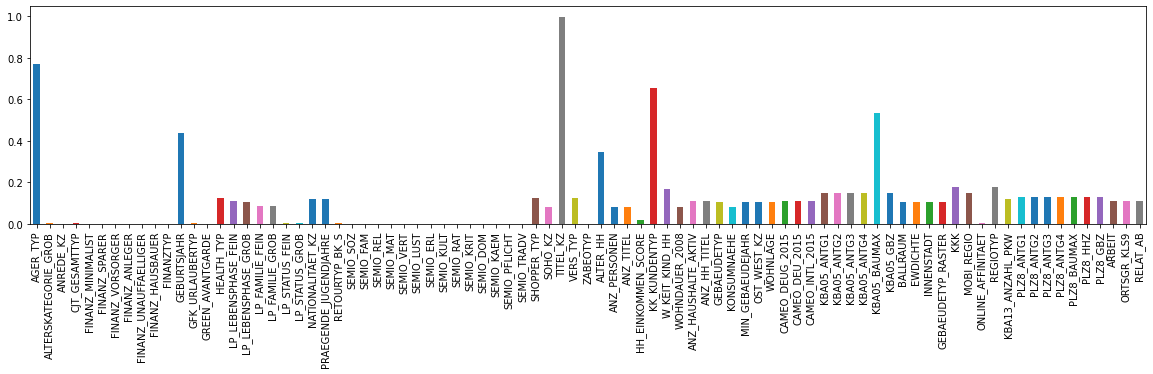

In [24]:
vc_nulls_prop['percentage'] = vc_nulls_prop.count_nils / azdias_copy.shape[0]

plt.figure(figsize=(20,4))
vc_nulls_prop['percentage'].plot(kind = 'bar')
plt.show() # About 5 columns have missing values that are above 50% of the entire population.

In [25]:
azdias_copy.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [26]:
vc_nulls.isna().value_counts()
#61 features have no missing values within, out of 85 features

False    61
True     24
Name: True, dtype: int64

<AxesSubplot:>

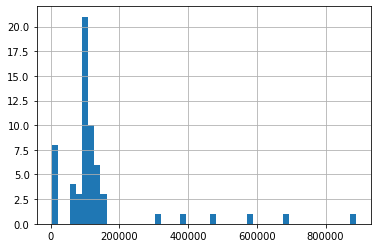

In [27]:
vc_nulls.hist(bins=50) # This histogram shows the distribution of missing values. 
#The distribution looks like a skewed Gaussian from 0 to 200000, with mean of about 150K.

In [28]:
vc_nulls.describe()
#For skewed Gaussian, we will attempt to remove outliers by Q3 + 1.5 (IQR)
#IQR = 116515 - 93148 = 23367

count        61.000000
mean     137259.180328
std      157104.019741
min        2881.000000
25%       93148.000000
50%       98979.000000
75%      116515.000000
max      889061.000000
Name: True, dtype: float64

In [29]:
statistics = vc_nulls.describe()
q3 = statistics['75%']
iqr = q3 - statistics['25%']

iqr
outlier_threshold = q3 + (1.5 * iqr)
# outlier_threshold - 151565.5 (dont'use - retain as many columns as possible: will drop 6 compared to 8)

In [30]:
outlier_threshold = 200000 #use 200k from the histogram just now as threshold to drop columns

In [31]:
# vc_nulls.describe()['mean'] + (2 * vc_nulls.describe()['std'])

In [32]:
# Investigate patterns in the amount of missing data in each column.
# Observation as follows:
# 1. After encoding, we find that there are a few columns with massive number of missing values (5 columns > 50% values)
# 2. The distribution of missing values follow a skewed normal distribution with mean about 137K (i.e. missing data in rows per column)
# 3. We propose to drop columns as features where missing values > 152K (use 200k)


In [33]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
col_to_drop = list(vc_nulls.loc[vc_nulls > outlier_threshold].index)
col_to_drop
#drop 8 columns: ['AGER_TYP', 'TITEL_KZ', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'KKK', 'REGIOTYP'] - original
#drop 6 columns: ['AGER_TYP', 'TITEL_KZ', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'] - use 200k threshold

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [34]:
azdias_copy = azdias_copy.drop(columns=col_to_drop)

<AxesSubplot:>

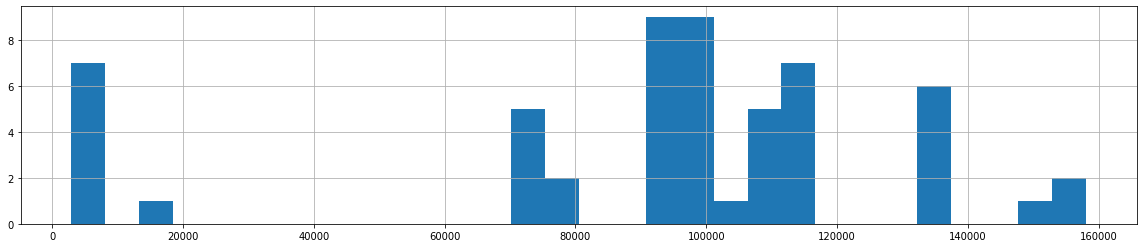

In [35]:
plt.figure(figsize=(20,4))
vc_nulls_new = azdias_copy.apply(lambda x: x.isnull().value_counts()).T[True]
vc_nulls_new.hist(bins=30) #check new distribution of data

In [36]:
dropped = azdias.loc[:,col_to_drop]
dropped #filter out columns with original data encodings (-1,0, nans)

,AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX
0,-1,0,NaN,NaN,NaN,NaN
1,-1,1996,0.0,0.0,NaN,5.0
2,-1,1979,0.0,17.0,NaN,0.0
3,2,1957,0.0,13.0,NaN,1.0
4,-1,1963,0.0,20.0,1.0,0.0
5,3,1943,0.0,10.0,3.0,0.0
6,-1,0,0.0,0.0,NaN,1.0
7,-1,1964,0.0,14.0,NaN,0.0
8,-1,1974,0.0,16.0,NaN,0.0
9,-1,1975,0.0,17.0,6.0,0.0


In [37]:
#find out for the 6 dropped columns, how many nans are there per row
counter=0
counter_list=[]
for idx, df in dropped.iterrows():
    for col in df.index:
#         print(df[col])
        if df[col] in [-1,0] or pd.isna(df[col]):
            counter+=1
    counter_list.append(counter)
    counter=0

In [38]:
dropped['new'] = counter_list

In [39]:
len(dropped.loc[dropped.new >=2]) / len(dropped)

0.9617524721702024

In [40]:
len(dropped.loc[dropped.new >=3]) / len(dropped)

0.7825410307880986

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Answer：
I've removed 6 columns as the number of missing values in these columns exceed the predetermined outlier threshold (from which a skewed normal distribution was derived for the distribution of missing values). Inspecting further the 6 columns and their interaction with each other above in the main dataset, I noted that for most of the rows, almost 2 columns (96%) and 3 columns (78%) were either 0, nan or -1, which means the columns have missing data that might be correlated to each other in terms of missing data. Hence, to drop these columns accordingly.

6 Dropped columns = ['AGER_TYP', 'TITEL_KZ', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
To drop for similar future dataset (customers)


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [41]:
azdias_copy.shape #6 columns removed

(891221, 79)

In [42]:
# How much data is missing in each row of the dataset?

count_nulls_row = azdias_copy.isnull().sum(axis=1)
count_nulls_row.sort_values(ascending=False)
#Max number of null values per row across columns is 49 (out of 79 columns)
#Number of rows with no missing values = 623K, 70%

732775    49
643174    49
472919    48
623938    47
40670     47
288717    47
98398     47
186542    47
186541    47
468480    47
623935    47
288730    47
749587    47
475759    47
288733    47
186536    47
40658     47
40662     47
288715    47
288734    47
40676     47
623927    47
623924    47
749599    47
623922    47
288700    47
623911    47
40684     47
186565    47
98382     47
          ..
540306     0
540305     0
540304     0
540303     0
540301     0
540300     0
540299     0
540325     0
540327     0
540355     0
540344     0
540354     0
540353     0
540351     0
540350     0
540349     0
540347     0
540346     0
540345     0
540343     0
540328     0
540340     0
540339     0
540338     0
540337     0
540336     0
540333     0
540332     0
540330     0
445610     0
Length: 891221, dtype: int64

In [43]:
(count_nulls_row.value_counts()[0]), (count_nulls_row.value_counts()[0])/len(azdias_copy)

(623423, 0.6995156083620112)

In [44]:
count_nulls_row.describe()
#Mean is about 6 columns with null values, with max about 49 columns of null values per row.

count    891221.000000
mean          5.648638
std          13.234726
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [45]:
count_nulls_row.value_counts().sort_values(ascending=False)
#no of rows with 0-3 missing columns = 623+16+28+17 = 684K (77% of total rows - not too bad)

0     623423
47     45578
2      27938
43     27369
8      24598
5      22520
3      17423
1      15742
6      13777
7      13730
4      12609
34     10816
10      5391
15      4765
35      3910
13      3254
9       3031
33      2985
16      2513
14      2248
19      1171
11      1105
12       763
17       671
37       538
45       494
38       421
18       406
41       356
20       350
32       207
44       155
21       151
40       137
23       132
22       128
36        84
39        77
24        68
26        59
25        55
27        24
42        21
29        11
30         6
28         5
31         3
49         2
48         1
dtype: int64

<AxesSubplot:>

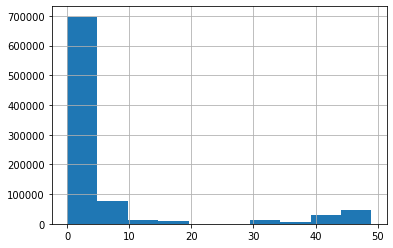

In [46]:
count_nulls_row.hist()
#this is a histogram of the distribution of columns with null data by count of rows. As seen from the chart, most of the rows
#have either no or very little missing columns. I will use 20 as the threshold to split the dataset, based on the distribution.

In [47]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

first_dataset = azdias_copy.loc[count_nulls_row <= 20]
second_dataset = azdias_copy.loc[count_nulls_row > 20]

In [48]:
print(first_dataset.shape) #89%
print(second_dataset.shape) #11%

(797428, 79)
(93793, 79)


In [49]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

vc_nulls_new = first_dataset.apply(lambda x: x.isnull().value_counts()).T[True]
vc_nulls_new

ALTERSKATEGORIE_GROB      2784.0
ANREDE_KZ                    NaN
CJT_GESAMTTYP             4634.0
FINANZ_MINIMALIST            NaN
FINANZ_SPARER                NaN
FINANZ_VORSORGER             NaN
FINANZ_ANLEGER               NaN
FINANZ_UNAUFFAELLIGER        NaN
FINANZ_HAUSBAUER             NaN
FINANZTYP                    NaN
GFK_URLAUBERTYP           4634.0
GREEN_AVANTGARDE             NaN
HEALTH_TYP               36419.0
LP_LEBENSPHASE_FEIN      49651.0
LP_LEBENSPHASE_GROB      46830.0
LP_FAMILIE_FEIN          31121.0
LP_FAMILIE_GROB          31121.0
LP_STATUS_FEIN            4634.0
LP_STATUS_GROB            4634.0
NATIONALITAET_KZ         33635.0
PRAEGENDE_JUGENDJAHRE    28458.0
RETOURTYP_BK_S            4634.0
SEMIO_SOZ                    NaN
SEMIO_FAM                    NaN
SEMIO_REL                    NaN
SEMIO_MAT                    NaN
SEMIO_VERT                   NaN
SEMIO_LUST                   NaN
SEMIO_ERL                    NaN
SEMIO_KULT                   NaN
          

In [50]:
vc_nulls_new = second_dataset.apply(lambda x: x.isnull().value_counts()).T[True]
vc_nulls_new #the 5 columns to choose are ANREDE_KZ, FINANZ_HAUSBAUER, SEMIO_SOZ,  SEMIO_KULT, GREEN_AVANTGARDE

ALTERSKATEGORIE_GROB        97.0
ANREDE_KZ                    NaN
CJT_GESAMTTYP              220.0
FINANZ_MINIMALIST            NaN
FINANZ_SPARER                NaN
FINANZ_VORSORGER             NaN
FINANZ_ANLEGER               NaN
FINANZ_UNAUFFAELLIGER        NaN
FINANZ_HAUSBAUER             NaN
FINANZTYP                    NaN
GFK_URLAUBERTYP            220.0
GREEN_AVANTGARDE             NaN
HEALTH_TYP               74777.0
LP_LEBENSPHASE_FEIN      47981.0
LP_LEBENSPHASE_GROB      47742.0
LP_FAMILIE_FEIN          46671.0
LP_FAMILIE_GROB          46671.0
LP_STATUS_FEIN             220.0
LP_STATUS_GROB             220.0
NATIONALITAET_KZ         74680.0
PRAEGENDE_JUGENDJAHRE    79706.0
RETOURTYP_BK_S             220.0
SEMIO_SOZ                    NaN
SEMIO_FAM                    NaN
SEMIO_REL                    NaN
SEMIO_MAT                    NaN
SEMIO_VERT                   NaN
SEMIO_LUST                   NaN
SEMIO_ERL                    NaN
SEMIO_KULT                   NaN
          

In [51]:
cols_chosen = ['ANREDE_KZ', 'FINANZ_HAUSBAUER', 'SEMIO_SOZ',  'SEMIO_KULT', 'GREEN_AVANTGARDE']

In [52]:
def draw_plots(col):
    fig, ax =plt.subplots(1,2)
#     plt.subplots_adjust(left=None, bottom=None, right=30, top=None, wspace=None, hspace=None)
    sns.countplot(first_dataset[col], ax=ax[0])
    sns.countplot(second_dataset[col], ax=ax[1])

    ax[0].set_title(f"First_dataset, {col}")
    ax[1].set_title(f"Second_dataset, {col}")

    fig.tight_layout(w_pad=5)
    fig.show()

/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following va

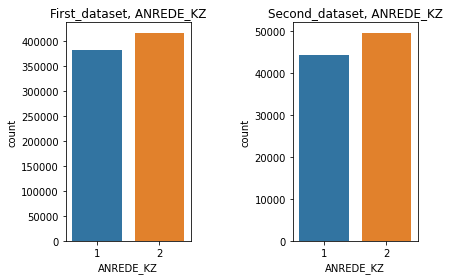

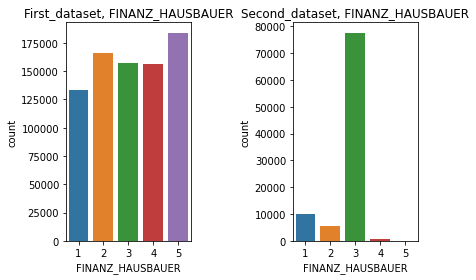

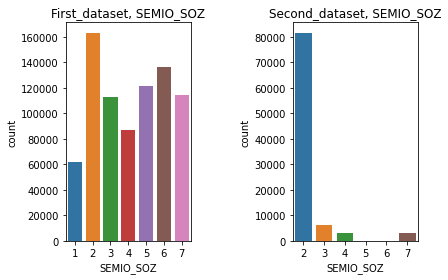

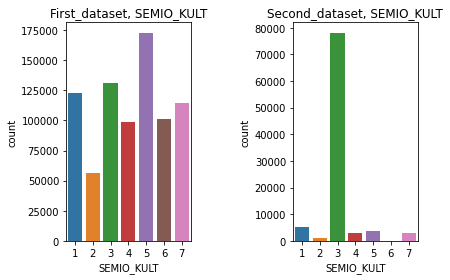

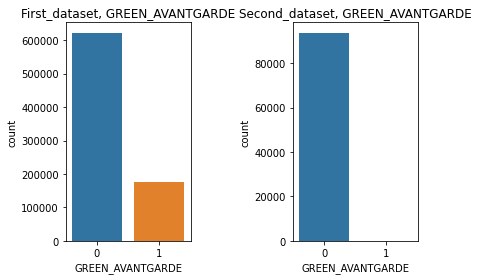

In [53]:
#The distribution of the data in the 5 chosen columns does not seem to be similar across the 2 datasets, except for
#ANREDE_KZ.
#Meaning, when comparing columns with no or very little missing values (the 5 selected cols), the distribution of the count
#of the values is significantly different between the dataset with 0-3 columns with empty values,
#and the dataset with more than 3 columns with emnpty values.
#In which case, the dropping of rows might not be trivial (since we expect the distribution to be similar).
for col in cols_chosen:
    draw_plots(col)

In [54]:
#To drop those with a lot of missing data. For purposes of this exercise, we will use
#first_dataset which consists of rows with 0 to max 3 columns with missing values.

first_dataset.shape
#797/891 = 89% of original dataset (in rows) retained.


(797428, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Ans: The observations are as follows:
1) There are 623K rows (out of 891K rows) with no missing values. This amounts to 70% of the entire dataset, which is not bad.
2) We split the dataset into one with 0 to 3 missing values, and the other one with more than 3 missing values per row across columns.
3) The conclusion we get by looking at the histogram of columns with no missing values is that the distribution of the values in these columns between the 2 datasets seem to be significantly different, which means dropping rows with 3 or more missing values might not be trivial.
4) For work purposes, we use the dataset with 0 to 3 missing values per row.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [55]:
# How many features are there of each data type?

feat_info.type.value_counts()
#49 ordinal, 21 categorical and 7 mixed variables (totalling about 90% of total columns)

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [56]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#List of categorical variables
cols_df = feat_info.loc[feat_info.type == 'categorical']
cat_cols = list(cols_df.attribute)
cat_cols

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [57]:
#I would not want to perform OH encoding
#for categorical features with a high number of possible values (multi-levels).
#This is because this will result in additional number of features which could result
#in model complexity.
#I would drop columns with values equals or above 3 (for multi-levels).

to_drop={}
for col in cat_cols:
    try:
        vals = first_dataset[col].unique()
    except:
        continue
    
    print(col, vals) #columns in reduced dataset with their values
    
    if len(vals) >= 3 or first_dataset[col].isna().any():
        to_drop[col] = 'DROP' 
    else:
        to_drop[col] = 'RETAIN'

ANREDE_KZ [2 1]
CJT_GESAMTTYP [ 5.  3.  2.  4.  1.  6. nan]
FINANZTYP [1 6 5 2 4 3]
GFK_URLAUBERTYP [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6. nan]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
LP_FAMILIE_GROB [ 3.  1. nan  5.  2.  4.]
LP_STATUS_FEIN [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
LP_STATUS_GROB [ 1.  2.  4.  5.  3. nan]
NATIONALITAET_KZ [ 1.  3.  2. nan]
SHOPPER_TYP [ 3.  2.  1.  0. nan]
SOHO_KZ [1. 0.]
VERS_TYP [ 2.  1. nan]
ZABEOTYP [5 3 4 1 6 2]
GEBAEUDETYP [8. 1. 3. 2. 6. 4. 5.]
OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' nan '3' 'X']
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' nan '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C'
 '9C' '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F'
 '5F' '1C' 'XX']


In [58]:
to_drop

{'ANREDE_KZ': 'RETAIN',
 'CJT_GESAMTTYP': 'DROP',
 'FINANZTYP': 'DROP',
 'GFK_URLAUBERTYP': 'DROP',
 'GREEN_AVANTGARDE': 'RETAIN',
 'LP_FAMILIE_FEIN': 'DROP',
 'LP_FAMILIE_GROB': 'DROP',
 'LP_STATUS_FEIN': 'DROP',
 'LP_STATUS_GROB': 'DROP',
 'NATIONALITAET_KZ': 'DROP',
 'SHOPPER_TYP': 'DROP',
 'SOHO_KZ': 'RETAIN',
 'VERS_TYP': 'DROP',
 'ZABEOTYP': 'DROP',
 'GEBAEUDETYP': 'DROP',
 'OST_WEST_KZ': 'RETAIN',
 'CAMEO_DEUG_2015': 'DROP',
 'CAMEO_DEU_2015': 'DROP'}

In [59]:
#Dropped 14 columns because too many categories to do OH encoding
#CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, 
#LP_STATUS_FEIN, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, VERS_TYP, ZABEOTYP, 'GABAEUDETYP', CAMEO_DEUG_2015, CAMEO_DEU_2015
cols_to_drop_new = [k for k,v in to_drop.items() if v == 'DROP']
first_dataset_new = first_dataset.drop(columns = cols_to_drop_new)
first_dataset_new.shape #79-14

(797428, 65)

In [60]:
resultant_cat_cols = [cat for cat in cat_cols if cat not in cols_to_drop_new]
resultant_cat_cols

['AGER_TYP',
 'ANREDE_KZ',
 'GREEN_AVANTGARDE',
 'SOHO_KZ',
 'TITEL_KZ',
 'KK_KUNDENTYP',
 'OST_WEST_KZ']

In [61]:
type_dict={}
for col in resultant_cat_cols:
    try:
        vals = first_dataset_new[col].unique()
    except:
        continue
    
#     print(col, vals) #columns in reduced dataset with their values
    
    #those with nas are removed so ohe not a problem downstream
    if len(vals) > 2:
        type_dict[col] = 'MULTILEVEL'
    else:
        type_dict[col] = 'BINARY'
    
    for item in vals:
        if isinstance(item, str):
             type_dict[col] = 'REENCODE'
                
type_dict
 
#Binary: 2 values
#Multi level: more than 2 values
#Reencode: those with non-numeric values

#4 binarys, 4 4 multilevels, 1 reencode
#OHE the following: LP_FAMILIE_GROB, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP

{'ANREDE_KZ': 'BINARY',
 'GREEN_AVANTGARDE': 'BINARY',
 'SOHO_KZ': 'BINARY',
 'OST_WEST_KZ': 'REENCODE'}

In [62]:
# Re-encode categorical variable(s) to be kept in the analysis.
#see below cells for work done.

In [63]:
multi_cat_cols_ohe = [k for k,v in type_dict.items() if v=='MULTILEVEL']
multi_cat_cols_ohe #all dropped in earlier cells

[]

In [64]:
#need to reencode last categorical column in the dictionary
#OST_WEST_KZ
ost_west_kz_encoded = pd.get_dummies(first_dataset.OST_WEST_KZ)

In [65]:
ost_west_kz_encoded

,O,W
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1
7,0,1
8,0,1
9,0,1
10,0,1


In [66]:
#drop original ost column
first_dataset_new = first_dataset_new.drop(columns=['OST_WEST_KZ'])

In [67]:
first_dataset_new.shape #65-1 dropping OST, with ost_dummies waiting

(797428, 64)

In [68]:
#perform ohe for the 4 cat multilevel columns - not necessary
# cat_dataset_ohe = first_dataset_new.loc[:,multi_cat_cols_ohe]

In [69]:
#remove the 4 columns for ohe from original dataset - not necessary
# first_dataset_new.drop(columns = multi_cat_cols_ohe, inplace=True)

In [70]:
# cat_dataset_ohe.columns - not necessary

In [71]:
# cat_dataset_ohe.head() - not necessary

In [72]:
# #Next, need to do OH encoding for the multilevel features. - not necessary
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# le = LabelEncoder()

# X = first_dataset_cat.apply(le.fit_transform)

# X.head(2)

In [73]:
# X.shape

In [74]:
#Create OneHotEncoder object and fit to cat_dataset_ohe - not necessary
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# onehotlabels = enc.fit_transform(cat_dataset_ohe).toarray()

# onehotlabels #no of rows remained intact, but columns increased from 15 to 56.

In [75]:
# newdf = pd.DataFrame(onehotlabels) - not necessary
# newdf = newdf.add_prefix('cat_ohe_')

In [76]:
# newdf.shape #4 columns to 17 columns - not necessary

In [77]:
first_dataset_new.shape

(797428, 64)

In [78]:
# print(cat_cols) - not necessary

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Ans: The original dataset was 891k rows and 85 columns. Out of the 85 columns, 6 were removed from the previous exercise on missing values as the number of missing values in these columns were considered outliers. Of the remaining 79 columns, dropped 14 more categorical columns because the range of values within these columns was too wide (3 or more), which could have rendered OH encoding less useful as there are more features which could potentially add to model complexity. [There were 21 categorical features from the original datset (fyi). ]

Subsequently, out of the 65 remaining columns, we reencoded 1 binary column. This was done using pd get dummies as the cat was in string. resultant new_dataframe was 65-1 = 64 columns, 3 cat columns remained: ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ. OST_WEST_KZ have 2 columns after encoding (to merge at end of day)

17 cat columns removed being AGER_TYP, TITEL_KZ, KK_KUNDERNTYP, CJT_GESAMTTYP, FINANZTYP, GFK_URLAUBERTYP, LP_FAMILIE_FEIN, LP_STATUS_FEIN, ZABEOTYP, VERS_TYP, GABAEUDETYP, CAMEO_DEUG_2015, CAMEO_DEU_2015,
LP_FAMILIE_GROB, LP_STATUS_GROB, NATIONALITAET_KZ, SHOPPER_TYP, OST_WEST_KZ

                        

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [79]:
#List of features with "mixed" categories
feat_info.loc[feat_info.type == 'mixed']
# dropped columns from original exercise
# ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
#KBA05_BAUMAX already dropped in first round of exercise

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [80]:
mixed_cols = feat_info.loc[feat_info.type == 'mixed'].attribute.tolist()
mixed_cols

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'KBA05_BAUMAX',
 'PLZ8_BAUMAX']

In [81]:
# first_dataset_new.LP_LEBENSPHASE_FEIN.unique() #No suitable intervals, plus values in this column have too wide a range, so not suitable for OH encoding. Drop
# first_dataset_new.LP_LEBENSPHASE_GROB.unique() #Hard to find clear intervals, same, values range above 5, drop
# first_dataset_new.PRAEGENDE_JUGENDJAHRE.unique() #See work done below 
# first_dataset_new.WOHNLAGE.unique() #Same, values range above 5, drop
# first_dataset_new.CAMEO_INTL_2015.unique() #See work done below
# KBA05_BAUMAX already dropped
first_dataset_new.PLZ8_BAUMAX.unique() #Same, values range above 5, drop

array([ 1.,  2., nan,  4.,  5.,  3.])

In [82]:
# PRAEGENDE_JUGENDJAHRE
# -  1: 40s - war years (Mainstream, E+W)
# -  2: 40s - reconstruction years (Avantgarde, E+W)
# -  3: 50s - economic miracle (Mainstream, E+W)
# -  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
# -  5: 60s - economic miracle (Mainstream, E+W)
# -  6: 60s - generation 68 / student protestors (Avantgarde, W)
# -  7: 60s - opponents to the building of the Wall (Avantgarde, E)
# -  8: 70s - family orientation (Mainstream, E+W)
# -  9: 70s - peace movement (Avantgarde, E+W)
# - 10: 80s - Generation Golf (Mainstream, W)
# - 11: 80s - ecological awareness (Avantgarde, W)
# - 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
# - 13: 80s - Swords into ploughshares (Avantgarde, E)
# - 14: 90s - digital media kids (Mainstream, E+W)
# - 15: 90s - ecological awareness (Avantgarde, E+W)

In [83]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
def clean_func_decade(val):
    if val in [1.0,2.0]:
        return 1 #40s
    elif val in [3.0,4.0]:
        return 2 #50s
    elif val in [5.0,6.0,7.0]:
        return 3 #60s
    elif val in [8.0,9.0]:
        return 4 #70s
    elif val in [10.0,11.0,12.0,13.0]:
        return 5 #80s
    elif val in [14.0,15.0]:
        return 6 #90s
    else:
        return val
    
def clean_func_movement(val):
    if val in [1.0,3.0,5.0,8.0,10.0,12.0,14.0]:
        return 1 #Mainstream
    elif val in [2.0, 4.0, 6.0, 7.0, 9.0, 11.0, 13.0, 15.0]:
        return 2 #Avantgarde
    else:
        return val

In [84]:
#2 new columns created from PRAEGENDE_JUGENDJAHRE for first_dataset_new
first_dataset_new['PRAEGENDE_JUGENDJAHRE_DECADE'] = first_dataset_new.PRAEGENDE_JUGENDJAHRE.apply(clean_func_decade)
# first_dataset_new.loc[:, ['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_DECADE']]

first_dataset_new['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = first_dataset_new.PRAEGENDE_JUGENDJAHRE.apply(clean_func_movement)
# first_dataset_new.loc[:, ['PRAEGENDE_JUGENDJAHRE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT']]
first_dataset_new.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace=True)

In [85]:
# German CAMEO: Wealth / Life Stage Typology, mapped to international code
# - -1: unknown
# - 11: Wealthy Households - Pre-Family Couples & Singles
# - 12: Wealthy Households - Young Couples With Children
# - 13: Wealthy Households - Families With School Age Children
# - 14: Wealthy Households - Older Families &  Mature Couples
# - 15: Wealthy Households - Elders In Retirement
# - 21: Prosperous Households - Pre-Family Couples & Singles
# - 22: Prosperous Households - Young Couples With Children
# - 23: Prosperous Households - Families With School Age Children
# - 24: Prosperous Households - Older Families & Mature Couples
# - 25: Prosperous Households - Elders In Retirement
# - 31: Comfortable Households - Pre-Family Couples & Singles
# - 32: Comfortable Households - Young Couples With Children
# - 33: Comfortable Households - Families With School Age Children
# - 34: Comfortable Households - Older Families & Mature Couples
# - 35: Comfortable Households - Elders In Retirement
# - 41: Less Affluent Households - Pre-Family Couples & Singles
# - 42: Less Affluent Households - Young Couples With Children
# - 43: Less Affluent Households - Families With School Age Children
# - 44: Less Affluent Households - Older Families & Mature Couples
# - 45: Less Affluent Households - Elders In Retirement
# - 51: Poorer Households - Pre-Family Couples & Singles
# - 52: Poorer Households - Young Couples With Children
# - 53: Poorer Households - Families With School Age Children
# - 54: Poorer Households - Older Families & Mature Couples
# - 55: Poorer Households - Elders In Retirement
# - XX: unknown

In [86]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def clean_func_wealth(val):
    if isinstance(val, float):
        val = str(val)
        
    if val.startswith('1'):
        return 1 #wealthy
    elif val.startswith('2'):
        return 2 #prosperous
    elif val.startswith('3'):
        return 3 #comfortable
    elif val.startswith('4'):
        return 4 #less affluent
    elif val.startswith('5'):
        return 5 #poorer
    elif val.startswith('X'):
        return np.nan 
    else:
        return np.nan
    
def clean_func_lifestage(val):
    if isinstance(val, float):
        val = str(val)
    
    if val.endswith('1'):
        return 1 #prefamily
    elif val.endswith('2'):
        return 2 #young couples
    elif val.endswith('3'):
        return 3 #families
    elif val.endswith('4'):
        return 4 #older families
    elif val.endswith('5'):
        return 5 #elders in ret
    elif val.endswith('X'):
        return np.nan 
    else:
        return np.nan

In [87]:
#2 new columns created from CAMEO_INTL_2015 for first_dataset_new
first_dataset_new['CAMEO_INTL_2015_WEALTH'] = first_dataset_new.CAMEO_INTL_2015.apply(clean_func_wealth)
# first_dataset_new.loc[:, ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_WEALTH']]

first_dataset_new['CAMEO_INTL_2015_LIFESTAGE'] = first_dataset_new.CAMEO_INTL_2015.apply(clean_func_lifestage)
# first_dataset_new.loc[:, ['CAMEO_INTL_2015', 'CAMEO_INTL_2015_LIFESTAGE']]

first_dataset_new.drop(columns = ['CAMEO_INTL_2015'], inplace=True)

In [88]:
ohe_mixed=[]
for col in mixed_cols:
    try:
        vals = first_dataset_new[col].unique()
    except:
        continue
        
    if len(vals) <= 3:
        ohe_mixed.append(col)
    else:
        first_dataset_new.drop(columns=[col], inplace=True)
        
ohe_mixed #all dropped

# ['LP_LEBENSPHASE_FEIN',
#  'LP_LEBENSPHASE_GROB',
#  'WOHNLAGE',
#  'PLZ8_BAUMAX']


[]

In [89]:
first_dataset_new.shape #64-2+4-4

(797428, 62)

In [90]:
first_dataset_new.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_A

In [91]:
# not necessary
# ohe_mixed_df_list=[]
# for col in ohe_mixed:
#     ohe_df = pd.DataFrame(first_dataset_new[col])
    
#     enc_1 = OneHotEncoder()
#     enc_1.fit(ohe_df)
#     onehotlabels_1 = enc_1.transform(ohe_df).toarray()
    
#     ohe_mixed_df = pd.DataFrame(onehotlabels_1)
#     ohe_mixed_df = ohe_mixed_df.add_prefix(f'mixed_ohe_{col}')
#     ohe_mixed_df_list.append(ohe_mixed_df)
    
#     first_dataset_new.drop(columns = [col], inplace=True)

In [92]:
# len(ohe_mixed_df_list)

In [93]:
# ohe_mixed_df_list[0].shape

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Ans: There were certain columns which did not have good intervals, or that the range of values were too wide to render OHE
effective. These were dropped. Out of the mixed category columns, 2 additional columns were engineered per work step (4 new columns).

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [94]:
first_dataset_new.shape

(797428, 62)

In [95]:
final_dataset = first_dataset_new.reset_index(drop=True)

In [96]:
final_dataset.head(2) #85 - 6 - 14 - 1 - 2 + 4 - 4 = 62

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE
0,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0


In [97]:
#add in the OH columns - not necessary
# final_dataset = pd.merge(final_dataset, newdf, left_index=True, right_index=True)

In [98]:
# final_dataset.shape #61 + 17

In [99]:
ost_west_kz_encoded = ost_west_kz_encoded.reset_index(drop=True)
final_dataset = pd.merge(final_dataset, ost_west_kz_encoded, left_index=True, right_index=True)

In [100]:
# not necessary
# for mixed_df in ohe_mixed_df_list:
#     final_dataset = pd.merge(final_dataset, mixed_df, left_index=True, right_index=True)

In [101]:
final_dataset.shape #62 + 2

(797428, 64)

In [102]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# Original dataset was 891K rows, 85 columns.
# 1) Dropped rows with more than 3 missing values across the columns - rows decreased from 891K to 684K
# 2) Out of 85 columns, dropped 6 columns with missing values > threshold (200,000) across rows.
# 3) Out of remaining 79 columns, dropped 14 categorical columns because not suitable for OH encoding (multi-levels).
# 4) Out of 65 remaining, dropped 1 catergorical due to string reencoding (to be ohe via pd get dummies: 2 to be added)
# 5) Out of 64 columns, dropped 2 mixed columns for special treatment (added 4 back)
# 6) Out of 62 columns, dropped 4 mixed columns because no good intervals
# 7) Out of 58 columns, added 2 (from point 4), added 4 (from point 5)
# 8) Total 64 columns


In [103]:
final_dataset.rename(columns={'O':'OST_WEST_KZ_O',
                        'W':'OST_WEST_KZ_W'}, inplace=True)

In [104]:
final_dataset.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE,OST_WEST_KZ_O,OST_WEST_KZ_W
0,1.0,2,1,5,2,5,4,5,0,3.0,...,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0,0,1
1,3.0,2,1,4,1,2,3,5,1,3.0,...,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0,0,1


In [105]:
final_dataset.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_A

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [106]:
# #working cell - ignore
# def clean_data(df):
#     """
#     Perform feature trimming, re-encoding, and engineering for demographics
#     data
    
#     INPUT: Demographics DataFrame
#     OUTPUT: Trimmed and cleaned demographics DataFrame
#     """
    
#     # Put in code here to execute all main cleaning steps:
    
#     # convert missing value codes into NaNs, ...
#     for col in df.columns:
#         try:
#             encoded_vals = json.loads(features[col].missing_or_unknown)
#         except:
#             continue
    
#         df[col] = df[col].apply(lambda x: np.nan if x in encoded_vals else x)
    
#     # remove selected columns and rows, ...

# #     #remove selected columns
# #     vc_nulls = df.apply(lambda x: x.isnull().value_counts()).T[True]
# #     statistics = vc_nulls.describe()
# #     q3 = statistics['75%']
# #     iqr = q3 - statistics['25%']
# #     outlier_threshold = q3 + (1.5 * iqr)
# #     col_to_drop = list(vc_nulls.loc[vc_nulls > outlier_threshold].index)
# #     df_new = df.drop(columns=col_to_drop)
# #     percent_retained_col = df_new.shape[1] / df.shape[1]
# #     print('columns retained (missing data in columns exercise): ', percent_retained_col)
    
#     #pre-select columns to drop
#     col_to_drop = ['AGER_TYP', 'TITEL_KZ', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
#     df_new = df.drop(columns=col_to_drop)
#     percent_retained_col = df_new.shape[1] / df.shape[1]
#     print('columns retained (missing data in columns exercise): ', percent_retained_col)
    
#     #remove selected rows
# #     count_nulls_row = df_new.isnull().sum(axis=1)
# #     statistics_new = count_nulls_row.describe()
# #     q3_new = statistics_new['75%']
# #     iqr_new = q3_new - statistics_new['25%']
# #     outlier_threshold_new = q3_new + (1.5 * iqr_new)

#     #drop rows with more than 3 columns of missing data
#     new_dataset = df_new.loc[count_nulls_row <= 3]
#     percent_retained_rows = new_dataset.shape[0] / df.shape[0]
#     print('rows retained (missing data in rows exercise): ', percent_retained_rows)
    
#     # select, re-encode, and engineer column values.
    
# # drop categorical columns with high range of values (>5) not suitable for OHE
# #     cols_df = feat_info.loc[feat_info.type == 'categorical']
# #     cat_cols = list(cols_df.attribute)
    
# #     to_drop={}
# #     for col in cat_cols:
# #         try:
# #             vals = new_dataset[col].unique()
# #         except:
# #             continue

# #         if len(vals) > 5 or new_dataset[col].isna().any():
# #             to_drop[col] = 'DROP' 
    
# #     cols_to_drop_new = [k for k,v in to_drop.items() if v == 'DROP']
# #     new_dataset = new_dataset.drop(columns = cols_to_drop_new)

#     #hardcode columns to drop from earlier analysis (13 in all)
#     cols_to_drop_new = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
#     'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
#                         'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
#     new_dataset = new_dataset.drop(columns = cols_to_drop_new)

# #     print(new_dataset.shape)
    
# #     resultant_cat_cols = [cat for cat in cat_cols if cat not in cols_to_drop_new]

#     #reencode columns with string values
# #     old method - do not use
# #     type_dict={}
# #     for col in resultant_cat_cols:
# #         try:
# #             vals = new_dataset[col].unique()
# #         except:
# #             continue
            
# #         #reencode control flow
# #         for item in vals:
# #             if isinstance(item, str):
# #                 type_dict[col] = 'REENCODE'
        
#         #multilevel control flow - dropped multilevels due to additional complexity (added number of columns)
# #         if len(vals) > 2:
# #             type_dict[col] = 'MULTILEVEL'
                    
# #     cols_to_reencode = [k for k,v in type_dict.items() if v == 'REENCODE']

# # Hardcode cols to reencode
#     cols_to_reencode = 'OST_WEST_KZ'
# #     reencoded_dfs=[]
# #     for col in cols_to_reencode:
#     cat_1 = pd.get_dummies(new_dataset[cols_to_reencode])
#     cat_1.reset_index(drop=True, inplace=True)
# #     reencoded_dfs.append(cat_1)
#     new_dataset.drop(columns = [cols_to_reencode], inplace=True)

# #     reencoded_df_final = pd.concat(reencoded_dfs, axis=1)
# #     reencoded_df_final = reencoded_df_final.reset_index(drop=True)
    
# #OH encoding for multilevels - not necessary now
# #     multi_cat_cols_ohe = [k for k,v in type_dict.items() if v == 'MULTILEVEL']
    
# #     ohe_cat_df_list=[]
# #     for col in multi_cat_cols_ohe:
# #         try:
# #             cat_ohe_df = pd.DataFrame(new_dataset[col]) #reencoded taken care of above
# #         except:
# #             continue
            
# #         enc = OneHotEncoder()
# #         enc.fit(cat_ohe_df)
# #         onehotlabels = enc.transform(cat_ohe_df).toarray()

# #         ohe_cat_df = pd.DataFrame(onehotlabels)
# #         ohe_cat_df = ohe_cat_df.add_prefix(f'cat_ohe_{col}')
# #         ohe_cat_df_list.append(ohe_cat_df)
# #         new_dataset.drop(columns = [col], inplace=True)

# #     ohe_cat_df_final = pd.concat(ohe_cat_df_list, axis=1)
# #     ohe_cat_df_final = ohe_cat_df_final.reset_index(drop=True)
    
# #     print(ohe_cat_df_final.shape)
# #     print(new_dataset.shape)
# #     print(reencoded_df_final.shape)
        
#     #handle mixed columns
# #     mixed_columns = feat_info.loc[feat_info.type == 'mixed'].attribute.tolist()
    
# #     mixed_cols=['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']
    
#     new_dataset['PRAEGENDE_JUGENDJAHRE_DECADE'] = new_dataset.PRAEGENDE_JUGENDJAHRE.apply(clean_func_decade)
#     new_dataset['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = new_dataset.PRAEGENDE_JUGENDJAHRE.apply(clean_func_movement)
#     new_dataset.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace=True)
    
#     new_dataset['CAMEO_INTL_2015_WEALTH'] = new_dataset.CAMEO_INTL_2015.apply(clean_func_wealth)
#     new_dataset['CAMEO_INTL_2015_LIFESTAGE'] = new_dataset.CAMEO_INTL_2015.apply(clean_func_lifestage)
#     new_dataset.drop(columns = ['CAMEO_INTL_2015'], inplace=True)
    
#     mixed_cols_to_drop = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE',
#                           'PLZ8_BAUMAX']
    
#     new_dataset.drop(columns = mixed_cols_to_drop, inplace=True)
    
# #     ohe_mixed=[]
# #     for col in mixed_cols:
        
# #         if col == 'PRAEGENDE_JUGENDJAHRE':
# #             new_dataset['PRAEGENDE_JUGENDJAHRE_DECADE'] = new_dataset.PRAEGENDE_JUGENDJAHRE.apply(clean_func_decade)
# #             new_dataset['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = new_dataset.PRAEGENDE_JUGENDJAHRE.apply(clean_func_movement)
# #             new_dataset.drop(columns = [col], inplace=True)

# #         elif col == 'CAMEO_INTL_2015':
# #             new_dataset['CAMEO_INTL_2015_WEALTH'] = new_dataset.CAMEO_INTL_2015.apply(clean_func_wealth)
# #             new_dataset['CAMEO_INTL_2015_LIFESTAGE'] = new_dataset.CAMEO_INTL_2015.apply(clean_func_lifestage)
# #             new_dataset.drop(columns = [col], inplace=True)
        
# #         try:
# #             vals = new_dataset[col].unique() #might have been dropped
# #         except:
# #             continue
       
# #         if len(vals) <= 5:
# #             ohe_mixed.append(col)
# #         else:
# #             new_dataset.drop(columns=[col], inplace=True)

# #     ohe_mixed_df_list=[]
# #     for col in ohe_mixed:
# #         ohe_df = pd.DataFrame(new_dataset[col])

# #         enc_1 = OneHotEncoder()
# #         enc_1.fit(ohe_df)
# #         onehotlabels_1 = enc_1.transform(ohe_df).toarray()

# #         ohe_mixed_df = pd.DataFrame(onehotlabels_1)
# #         ohe_mixed_df = ohe_mixed_df.add_prefix(f'mixed_ohe_{col}')
# #         ohe_mixed_df_list.append(ohe_mixed_df)

# #         new_dataset.drop(columns = [col], inplace=True)

# #     ohe_mixed_df_final = pd.concat(ohe_mixed_df_list, axis=1)
# #     ohe_mixed_df_final = ohe_mixed_df_final.reset_index(drop=True)
    
#     new_dataset = new_dataset.reset_index(drop=True)
# #     print(new_dataset.shape)
# #     print(ohe_mixed_df.shape)
         
#     # Return the cleaned dataframe.
# #     final_df = pd.concat([new_dataset,reencoded_df_final,ohe_cat_df_final,ohe_mixed_df_final],axis=1)

#     final_df = pd.merge(new_dataset, cat_1, left_index=True, right_index=True)
#     print(final_df.shape)
#     return final_df

In [107]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    for col in df.columns:
        try:
            encoded_vals = json.loads(features[col].missing_or_unknown)
        except:
            continue
    
        df[col] = df[col].apply(lambda x: np.nan if x in encoded_vals else x)
    
    # remove selected columns and rows, ...
    
    #pre-select columns to drop
    col_to_drop = ['AGER_TYP', 'TITEL_KZ', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_new = df.drop(columns=col_to_drop)
    percent_retained_col = df_new.shape[1] / df.shape[1]
    print('columns retained (missing data in columns exercise): ', percent_retained_col)
    
    #remove selected rows
    #drop rows with more than 20 columns of missing data
    count_nulls_row = df_new.isnull().sum(axis=1)
    new_dataset = df_new.loc[count_nulls_row <= 20]
    percent_retained_rows = new_dataset.shape[0] / df.shape[0]
    print('rows retained (missing data in rows exercise): ', percent_retained_rows)
    
    # select, re-encode, and engineer column values.

    #hardcode columns to drop from earlier analysis (13 in all)
    cols_to_drop_new = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 
    'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP',
    'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    new_dataset = new_dataset.drop(columns = cols_to_drop_new)

    # Hardcode cols to reencode (1 binary variable with non-numeric values)
    cols_to_reencode = 'OST_WEST_KZ'
    cat_1 = pd.get_dummies(new_dataset[cols_to_reencode])
    cat_1.reset_index(drop=True, inplace=True)
    new_dataset.drop(columns = [cols_to_reencode], inplace=True)
  
    # Re-engineer new features from PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    new_dataset['PRAEGENDE_JUGENDJAHRE_DECADE'] = new_dataset.PRAEGENDE_JUGENDJAHRE.apply(clean_func_decade)
    new_dataset['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = new_dataset.PRAEGENDE_JUGENDJAHRE.apply(clean_func_movement)
    new_dataset.drop(columns = ['PRAEGENDE_JUGENDJAHRE'], inplace=True)
    
    new_dataset['CAMEO_INTL_2015_WEALTH'] = new_dataset.CAMEO_INTL_2015.apply(clean_func_wealth)
    new_dataset['CAMEO_INTL_2015_LIFESTAGE'] = new_dataset.CAMEO_INTL_2015.apply(clean_func_lifestage)
    new_dataset.drop(columns = ['CAMEO_INTL_2015'], inplace=True)
    
    # Drop remaining mixed columns
    mixed_cols_to_drop = ['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE',
                          'PLZ8_BAUMAX']
    
    new_dataset.drop(columns = mixed_cols_to_drop, inplace=True)
           
    new_dataset = new_dataset.reset_index(drop=True)

    final_df = pd.merge(new_dataset, cat_1, left_index=True, right_index=True)
    
    final_df.rename(columns={'O':'OST_WEST_KZ_O',
                        'W':'OST_WEST_KZ_W'}, inplace=True)
    
    print(final_df.shape)
    return final_df

In [108]:
#test on demographics data
cleaned_dataset = clean_data(azdias)

columns retained (missing data in columns exercise):  0.9294117647058824
rows retained (missing data in rows exercise):  0.894758987950239
(797428, 64)


In [109]:
cleaned_dataset.shape

(797428, 64)

In [110]:
cleaned_dataset.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',
       'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT',
       'ORTSGR_KLS9', 'RELAT_A

In [111]:
assert final_dataset.shape[0] == cleaned_dataset.shape[0], "clean_data function is not working properly, rows mismatch"
assert final_dataset.shape[1] == cleaned_dataset.shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [112]:
final_dataset.shape

(797428, 64)

In [113]:
final_dataset.columns[final_dataset.isna().any()].tolist() #numerous columns have null values

['ALTERSKATEGORIE_GROB',
 'HEALTH_TYP',
 'RETOURTYP_BK_S',
 'W_KEIT_KIND_HH',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'KONSUMNAEHE',
 'KBA05_ANTG1',
 'KBA05_ANTG2',
 'KBA05_ANTG3',
 'KBA05_ANTG4',
 'KBA05_GBZ',
 'BALLRAUM',
 'EWDICHTE',
 'INNENSTADT',
 'GEBAEUDETYP_RASTER',
 'KKK',
 'MOBI_REGIO',
 'ONLINE_AFFINITAET',
 'REGIOTYP',
 'KBA13_ANZAHL_PKW',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_HHZ',
 'PLZ8_GBZ',
 'ARBEIT',
 'ORTSGR_KLS9',
 'RELAT_AB',
 'PRAEGENDE_JUGENDJAHRE_DECADE',
 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',
 'CAMEO_INTL_2015_WEALTH',
 'CAMEO_INTL_2015_LIFESTAGE']

In [114]:
final_dataset.head(10)['W_KEIT_KIND_HH'] #this is one of the columns with missing values
#row 2 has nan values

0    3.0
1    3.0
2    NaN
3    2.0
4    6.0
5    3.0
6    5.0
7    5.0
8    4.0
9    6.0
Name: W_KEIT_KIND_HH, dtype: float64

In [115]:
final_dataset.columns.get_loc('W_KEIT_KIND_HH') #this column is column 29

29

In [116]:
final_dataset.describe()['W_KEIT_KIND_HH'] #median is 4 - so row 9 should be filled with 4 (via median imputing)

count    738528.000000
mean          4.162048
std           1.778702
min           1.000000
25%           3.000000
50%           4.000000
75%           6.000000
max           6.000000
Name: W_KEIT_KIND_HH, dtype: float64

In [117]:
len(final_dataset.loc[final_dataset.isna().any(1)]) #174k out of 797k rows with missing values = 22% of total rows (not trivial)

174217

In [118]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

#On investigating, there are about 61k rows with missing values in the final dataset. This amounts to 4% of total rows.
#I've decided to use simple imputing (median) to deal with these missing values as the number of rows 
#with missing values is not trivial (4%).
#I used median instead of mean as it better deals with skewness in data.

from sklearn.preprocessing import Imputer
impute_median = Imputer(missing_values=np.nan, strategy='median')
X = impute_median.fit_transform(final_dataset)

X

array([[1., 2., 1., ..., 1., 0., 1.],
       [3., 2., 1., ..., 4., 0., 1.],
       [4., 2., 4., ..., 2., 0., 1.],
       ...,
       [2., 2., 2., ..., 4., 0., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [4., 1., 4., ..., 3., 0., 1.]])

In [119]:
X.shape #shape is retained

(797428, 64)

In [120]:
X[2][29] #yes, imputing done correctly - 4

4.0

In [121]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
output = ss.fit_transform(X)

In [122]:
output.shape #shape is retained

(797428, 64)

In [123]:
final_df = pd.DataFrame(output)
final_df.isna().any().all() #confirmed no np.nan values

False

In [124]:
final_df.columns = list(final_dataset.columns) #rename to original columns

In [125]:
final_df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE,OST_WEST_KZ_O,OST_WEST_KZ_W
0,-1.766331,0.958068,-1.494610,1.538198,-1.040726,1.466447,0.959675,1.338819,-0.530567,1.096157,...,0.573848,-0.166595,-0.127146,0.684745,1.172701,-0.530567,1.185975,-1.266760,-0.517487,0.517487
1,0.200591,0.958068,-1.494610,0.864823,-1.766955,-0.570799,0.244961,1.338819,1.884778,1.096157,...,0.573848,-0.166595,-0.127146,-0.789154,1.172701,1.884778,-0.868283,0.761226,-0.517487,0.517487
2,1.184052,0.958068,0.683149,-0.481928,1.137960,-0.570799,-1.184467,-0.792030,-0.530567,-0.257263,...,0.573848,-1.170129,-0.997688,-0.052205,-0.223456,-0.530567,-1.553036,-0.590765,-0.517487,0.517487
3,0.200591,-1.043767,0.683149,0.191448,0.411731,-1.249880,0.244961,-0.792030,-0.530567,1.096157,...,-0.337337,0.836938,0.308126,1.421695,-0.223456,-0.530567,0.501222,0.085231,-0.517487,0.517487
4,-1.766331,0.958068,-0.042771,-1.155303,1.137960,-0.570799,-0.469753,1.338819,-0.530567,1.096157,...,1.485032,-1.170129,-0.997688,-0.052205,-1.619613,-0.530567,1.185975,0.761226,-0.517487,0.517487


In [126]:
final_df.shape #shape is retained

(797428, 64)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Ans: There were nan values in the dataset after section 1. These were not trivial (22%, 174k rows). Hence, I dealt with 
those via median imputing (compared to mean imputing) as there could be skewness in the data in the respective columns.

After which, Standard Scaler is applied to scale the data with mean 0 and standard deviation 1. Shape of the resultant
dataframe is retained (797k rows, 64 columns).

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [127]:
# Apply PCA to the data. USe half the number of features approx 40

from sklearn.decomposition import PCA

def do_pca(num_com,df):
    pca = PCA (n_components=num_com, random_state=42)
    X_pca = pca.fit_transform(df)
    
    return pca, X_pca

# pca = PCA(n_components=40)
# X_pca = pca.fit_transform(final_df)

# do_pca(40,final_df)

In [128]:
#Pull from lesson
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantation of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

In [129]:
for comp in range(3, final_df.shape[1]+1):
    pca, X_pca = do_pca(comp, final_df)
    
    n_comps = len(pca.explained_variance_ratio_)
    explained_var = pca.explained_variance_ratio_.sum()

    if explained_var > 0.85:
        break
    
    print(f'No.of components: {n_comps}, Explained_var: {explained_var}')

print(f'Final number of components to be used: {n_comps}') #26 components to be used, 38 features dropped/transformed

No.of components: 3, Explained_var: 0.3974661081226897
No.of components: 4, Explained_var: 0.45139898035745696
No.of components: 5, Explained_var: 0.4928039102282668
No.of components: 6, Explained_var: 0.5254792769242645
No.of components: 7, Explained_var: 0.5549390882831702
No.of components: 8, Explained_var: 0.5820873522542425
No.of components: 9, Explained_var: 0.6062276684736437
No.of components: 10, Explained_var: 0.6273575215381003
No.of components: 11, Explained_var: 0.6482355648094538
No.of components: 12, Explained_var: 0.6673040715106576
No.of components: 13, Explained_var: 0.686110212149241
No.of components: 14, Explained_var: 0.7035491643054806
No.of components: 15, Explained_var: 0.7207460582227508
No.of components: 16, Explained_var: 0.7370039814366376
No.of components: 17, Explained_var: 0.7526691320838979
No.of components: 18, Explained_var: 0.767043036816031
No.of components: 19, Explained_var: 0.7804107494671746
No.of components: 20, Explained_var: 0.7935228103870419


In [130]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=26, random_state=42)
X_pca = pca.fit_transform(final_df)

In [131]:
pca.explained_variance_ratio_.sum()

0.8570021635931149

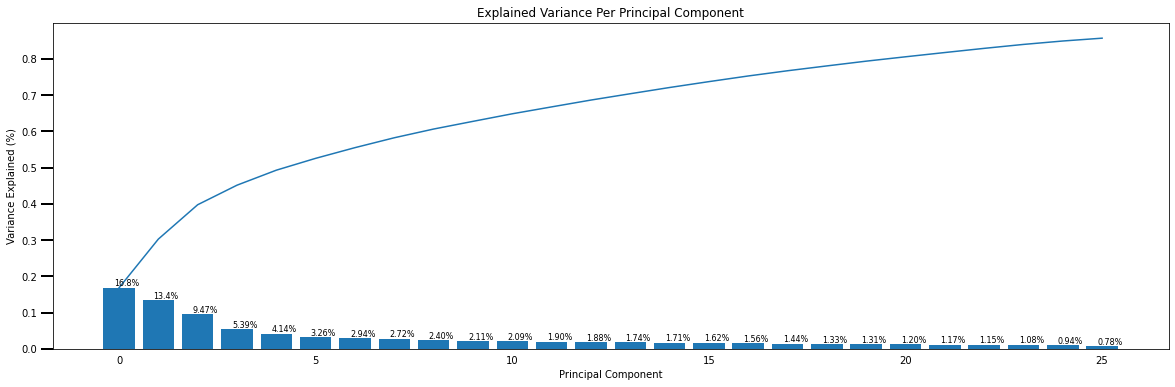

In [132]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

#First component explains 16.8% of the variance, followed by 13.4% for 2nd, 9.47% third etc.
#Top 3 component explains 40% of the variance in the data.

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Ans: I am retaining 26 transformed features out of the original 65 columns (post data processing). The 26 features can explain up to 85% of the variability of the cleaned dataset hence that is considered good enough, and scaling down from 65 to 26 leads to potential time savings while also reducing noise/model complexity.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [133]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

X_pca.shape

(797428, 26)

In [134]:
def map_weights(pca_comp_position,df):
    
    result = pd.DataFrame(pca.components_[pca_comp_position].T, index=df.columns)
    result.columns=['weight']
    result = result.sort_values(by=['weight'], ascending=False)
    
    result.reset_index(inplace=True)
    
    top5_bottom5 = result.head(5).append(result.tail(5))
    
    display(result)
    
    plotted = top5_bottom5.plot(kind='bar', x='index', y='weight')

    for p in plotted.patches:
        plotted.annotate(f'{p.get_height():0.3f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    plt.show()

,index,weight
0,PLZ8_ANTG3,0.227038
1,PLZ8_ANTG4,0.220574
2,CAMEO_INTL_2015_WEALTH,0.207610
3,HH_EINKOMMEN_SCORE,0.203982
4,ORTSGR_KLS9,0.197542
5,EWDICHTE,0.195078
6,FINANZ_HAUSBAUER,0.164042
7,KBA05_ANTG4,0.156242
8,PLZ8_ANTG2,0.153318
9,ARBEIT,0.146226


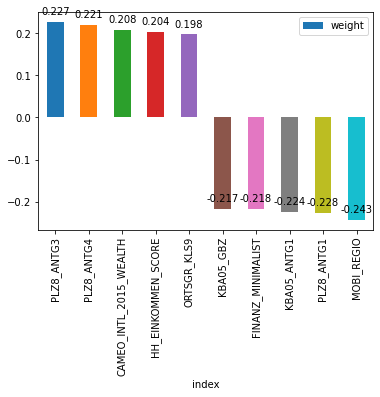

In [135]:
#first component result
map_weights(0,final_df)

#Observation: For the first component, plz8_antg3 and 4 makes up top 2 weights. From data dictionary, this feature
#relates to number of houses (6-10) and (>10) in the plz8 region - since they are both positive numbers, 
#they are positively correlated. This is a bit surprising, because high number of houses in 6-10 should lead to low/zero number
#of houses >10. Perhaps the data was not keyed or collected properly/misintepreted.

#Looking at the last values, plz8 and kba05(antg1) make up the last 2 biggest negative weights. The column means
#number of houses (1 to 2) in the plz8 or microcell region, which goes in negative direction to the top 2 (no of houses 6-10 
#and >10). This makes sense, since high number of 6-10/>10 houses will mean low number of 1-2 houses.
#Last feature of mobi_regio talks about movement pattern, which is highly negative. Meaning as number of houses increase, 
#this indicates very little movement. This makes sense as well as those with more houses might be entrenched at 1 or 2 houses
#and not move around (others are investments maybe), compared to those with 1 or 2 tending to relocate and move more.

#Conclusion: First PC probably incorporates latent features of number of houses with movement patterns.

,index,weight
0,ALTERSKATEGORIE_GROB,0.261844
1,FINANZ_VORSORGER,0.233551
2,SEMIO_ERL,0.231736
3,SEMIO_LUST,0.184714
4,RETOURTYP_BK_S,0.163747
5,W_KEIT_KIND_HH,0.119210
6,FINANZ_HAUSBAUER,0.116027
7,SEMIO_KRIT,0.114870
8,SEMIO_KAEM,0.111598
9,ANREDE_KZ,0.090480


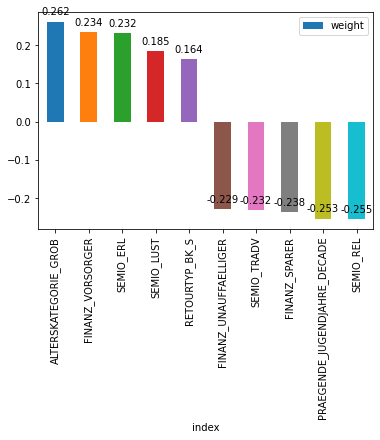

In [136]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#second component result
map_weights(1,final_df)

#Observation:
#First 3 relate to Alter (age), semio_erl (for event oriented people, their personaility), and finanz 
#(level of prepardeness on financial planning). These 3 have high positive values and are positively correlated to each other.
#They probably talk about age and personality and finance_preparedness (as age goes up, lower affinity in personality, lower
#financial savvyness)

#Bottom 3 are as follows: Finanz Sparer (savvyness of money_saver), PRAEGENDE_JUGENDJAHRE (decade, age) and semio_rel 
#(how religious one is). PRAEGENDE_JUGENDJAHRE increases, age decreases. As age increases, become less of a money_saver and
#more religious. This is in line with common understanding.

#Second PC incorporates age and its correlation to personality, financial_savvyness and reliogiosity.

,index,weight
0,SEMIO_VERT,0.345328
1,SEMIO_SOZ,0.262133
2,SEMIO_FAM,0.249715
3,SEMIO_KULT,0.234980
4,FINANZ_MINIMALIST,0.156403
5,RETOURTYP_BK_S,0.108532
6,FINANZ_VORSORGER,0.100591
7,W_KEIT_KIND_HH,0.091029
8,ALTERSKATEGORIE_GROB,0.079464
9,SEMIO_REL,0.069251


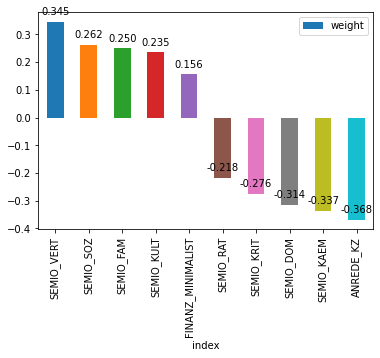

In [137]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(2,final_df)

#Observation
#Top 4 features are all related to personaility, and they move in the same direction for people who are
#dreamful, socially minded, family and cultural minded.

#Bottom features relate to personality (but in opposite direction for those who are rational, critical, dominant, combative).
#This is logical. Last feature is gender (higher is female). Female relate to top personality traits (social and family minded),
#males are more dominant. This is logical as well.

#Third PC incorporates gender and personality into 1 component.

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Ans: Yes, from the analysis done above, the top positive and negative values from the 3 PCs can be intepretated meaningfully.
For instance, for PC1, the component mainly incoporates number of houses owned and correlates to the extent of movement (more houses, less movement). For PC2, the component focus on age and personality and financial savvyness, where higher age generally leads to a lower financial savvyness and higher religiosity). For PC3, the component uses gender and personality, where it was found to have correlation between females and family/social/cultural minded personaility, compared to males (dominant, rational, critical character traits).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [138]:
X_pca.shape

(797428, 26)

In [139]:
from sklearn.cluster import KMeans, MiniBatchKMeans

# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    
# run k-means clustering on the data and...(use MiniBatchKMeans)
    kmeans = MiniBatchKMeans(n_clusters=center, random_state=42, batch_size=6)
    model = kmeans.fit(data)
    
# compute the average within-cluster distances.
    score = np.abs(model.score(data))
    
    return score

scores = []
centers = list(range(1,11))

for center in centers:
    scores.append(get_kmeans_score(X_pca, center))

print(scores)

[44117228.30896231, 39031490.65467385, 36234402.28764473, 32932435.250184458, 31017329.879812926, 30201352.188095953, 32154209.542072028, 28517901.246180143, 28011993.863066237, 27658224.671380125]


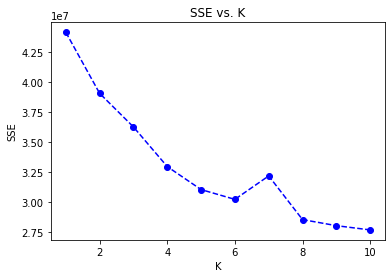

In [140]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

#5 clusters seem to be the optimal number of clusters

In [141]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
#Note - used mini batch k means for faster inference

kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=6)
model = kmeans.fit(X_pca)
preds = model.predict(X_pca)

preds

array([3, 0, 0, ..., 1, 3, 4], dtype=int32)

In [142]:
preds.shape

(797428,)

In [143]:
#might need to use silouhette as not confirmative enough.
from sklearn.metrics import silhouette_score

silhouette_avg_kmeans = silhouette_score(X_pca[:5000], preds[:5000])

In [144]:
silhouette_avg_kmeans

0.09718410564119781

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Ans: From the elbow plot, optimal number of clusters for the general population (after cleaning data and PCA) is 3. This is based on kmeans score which computes avg distance of points from their centers of their assigned clusters.

In [145]:
#Question - the elbow plot is actually not that obvious so I used the silhouette score given that there are no labels to
#use ARI or internal validation. The silhouette score is actually very low (memory issue - run at 5000) 
#- means something is not right? Maybe the clusters are not well separated, or is 2 ring or DBSCAN in nature?

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [146]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [147]:
customers.shape

(191652, 85)

In [148]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#Apply preprocessing
final_df_customers = clean_data(customers)

columns retained (missing data in columns exercise):  0.9294117647058824
rows retained (missing data in rows exercise):  0.7390478575751883
(141640, 64)


In [149]:
final_df_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE,OST_WEST_KZ_O,OST_WEST_KZ_W
0,4.0,1,5,1,5,1,2,2,1,1.0,...,5.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0,0,1
1,4.0,2,5,1,5,1,4,4,1,2.0,...,2.0,3.0,5.0,3.0,2.0,2.0,3.0,4.0,0,1
2,4.0,1,5,1,5,2,1,2,0,2.0,...,4.0,1.0,3.0,1.0,1.0,1.0,2.0,4.0,0,1
3,3.0,1,3,1,4,4,5,2,0,3.0,...,3.0,3.0,5.0,1.0,4.0,1.0,4.0,1.0,0,1
4,3.0,1,5,1,5,1,2,3,1,3.0,...,5.0,3.0,7.0,5.0,2.0,2.0,3.0,4.0,0,1


In [150]:
final_df_customers.shape

(141640, 64)

In [151]:
#apply imputation and feature scaling (use transform instead of fit_transform)
X_customers = impute_median.transform(final_df_customers)
output_customers = ss.transform(X_customers)

final_df_customers_1 = pd.DataFrame(output_customers)
final_df_customers_1.columns = list(final_df_customers.columns)

In [152]:
#apply feature transformation and pca
customers_pca = pca.transform(final_df_customers_1)

In [153]:
pca.explained_variance_ratio_.sum()

0.8570021635931149

In [154]:
#perform clustering and prediction
preds_customers = model.predict(customers_pca)

preds_customers

array([2, 0, 2, ..., 2, 0, 2], dtype=int32)

In [155]:
preds_customers.shape

(141640,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [156]:
print(final_df.shape)
print(preds.shape)

final_df['cluster'] = preds

(797428, 64)
(797428,)


In [157]:
print(final_df_customers_1.shape)
print(preds_customers.shape)

final_df_customers_1['cluster'] = preds_customers

(141640, 64)
(141640,)


In [158]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

#By numerical comparison
cluster_0_demo = len(final_df.loc[final_df.cluster == 0])/final_df.shape[0]
cluster_0_cust = len(final_df_customers.loc[final_df_customers_1.cluster == 0])/final_df_customers_1.shape[0]

cluster_1_demo = len(final_df.loc[final_df.cluster == 1])/final_df.shape[0]
cluster_1_cust = len(final_df_customers.loc[final_df_customers_1.cluster == 1])/final_df_customers_1.shape[0]

cluster_2_demo = len(final_df.loc[final_df.cluster == 2])/final_df.shape[0]
cluster_2_cust = len(final_df_customers.loc[final_df_customers_1.cluster == 2])/final_df_customers_1.shape[0]

cluster_3_demo = len(final_df.loc[final_df.cluster == 3])/final_df.shape[0]
cluster_3_cust = len(final_df_customers.loc[final_df_customers_1.cluster == 3])/final_df_customers_1.shape[0]

cluster_4_demo = len(final_df.loc[final_df.cluster == 4])/final_df.shape[0]
cluster_4_cust = len(final_df_customers.loc[final_df_customers_1.cluster == 4])/final_df_customers_1.shape[0]

print(f"Cluster 0 (Cust vs Demo): {cluster_0_cust} vs {cluster_0_demo}")
print(f"Cluster 1 (Cust vs Demo): {cluster_1_cust} vs {cluster_1_demo}")
print(f"Cluster 2 (Cust vs Demo): {cluster_2_cust} vs {cluster_2_demo}")
print(f"Cluster 3 (Cust vs Demo): {cluster_3_cust} vs {cluster_3_demo}") 
print(f"Cluster 4 (Cust vs Demo): {cluster_4_cust} vs {cluster_4_demo}") 

Cluster 0 (Cust vs Demo): 0.24538266026546174 vs 0.20138119052754605
Cluster 1 (Cust vs Demo): 0.025042360914995763 vs 0.17583405649162057
Cluster 2 (Cust vs Demo): 0.49909630048009035 vs 0.18467874215603164
Cluster 3 (Cust vs Demo): 0.019655464558034453 vs 0.18668770095858184
Cluster 4 (Cust vs Demo): 0.2108232137814177 vs 0.2514183098662199


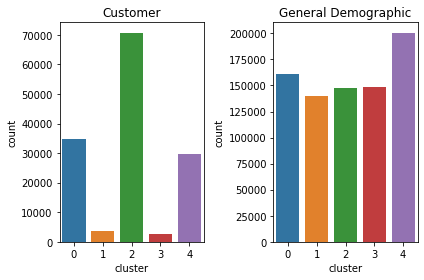

In [159]:
#Visualisation - seaborn
fig, ax =plt.subplots(1,2)
sns.countplot(x="cluster", data=final_df_customers_1, ax=ax[0])
sns.countplot(x="cluster", data=final_df, ax=ax[1])

ax[0].set_title("Customer")
ax[1].set_title("General Demographic")

plt.tight_layout()
plt.show()

#Observations (before accounting for dropped cluster):
# 1) Cluster 0 (slightly) and 2 are overepresented in customers compared to demographics (in terms of proportion), 
# while clusters 1 and 3 are underepresented. The company should then focus on persons and features of cluster 2.

In [160]:
#Handle dropped rows and their percentages
second_dataset.shape
total_demo = len(final_df.loc[final_df.cluster == 0]) + len(final_df.loc[final_df.cluster == 1]) + \
len(final_df.loc[final_df.cluster == 2]) + len(final_df.loc[final_df.cluster == 3]) + \
len(final_df.loc[final_df.cluster == 4]) + second_dataset.shape[0]

In [161]:
total_demo

891221

In [162]:
col_to_drop = ['AGER_TYP', 'TITEL_KZ', 'GEBURTSJAHR', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
cust_new = customers.drop(columns=col_to_drop)

count_nulls_row_customers = cust_new.isnull().sum(axis=1)
second_dataset_customers = cust_new.loc[count_nulls_row_customers > 20]

total_cust = len(final_df_customers_1.loc[final_df_customers_1.cluster == 0]) + \
+ len(final_df_customers_1.loc[final_df_customers_1.cluster == 1]) + \
len(final_df_customers_1.loc[final_df_customers_1.cluster == 2]) + len(final_df_customers_1.loc[final_df_customers_1.cluster == 3]) + \
len(final_df_customers_1.loc[final_df_customers_1.cluster == 4]) + second_dataset_customers.shape[0]

In [163]:
total_cust

191652

In [164]:
cluster_0_demo_new = len(final_df.loc[final_df.cluster == 0])/total_demo
cluster_1_demo_new = len(final_df.loc[final_df.cluster == 1])/total_demo
cluster_2_demo_new = len(final_df.loc[final_df.cluster == 2])/total_demo
cluster_3_demo_new = len(final_df.loc[final_df.cluster == 3])/total_demo
cluster_4_demo_new = len(final_df.loc[final_df.cluster == 4])/total_demo
cluster_5_demo_new = second_dataset.shape[0] / total_demo

cluster_0_cust_new = len(final_df_customers_1.loc[final_df_customers_1.cluster == 0])/total_cust
cluster_1_cust_new = len(final_df_customers_1.loc[final_df_customers_1.cluster == 1])/total_cust
cluster_2_cust_new = len(final_df_customers_1.loc[final_df_customers_1.cluster == 2])/total_cust
cluster_3_cust_new = len(final_df_customers_1.loc[final_df_customers_1.cluster == 3])/total_cust
cluster_4_cust_new = len(final_df_customers_1.loc[final_df_customers_1.cluster == 4])/total_cust
cluster_5_cust_new = second_dataset_customers.shape[0] / total_cust

print(f"New Cluster 0 (Cust vs Demo): {cluster_0_cust_new} vs {cluster_0_demo_new}")
print(f"New Cluster 1 (Cust vs Demo): {cluster_1_cust_new} vs {cluster_1_demo_new}")
print(f"New Cluster 2 (Cust vs Demo): {cluster_2_cust_new} vs {cluster_2_demo_new}")
print(f"New Cluster 3 (Cust vs Demo): {cluster_3_cust_new} vs {cluster_3_demo_new}")
print(f"New Cluster 4 (Cust vs Demo): {cluster_4_cust_new} vs {cluster_4_demo_new}")
print(f"New Cluster 5 (Cust vs Demo): {cluster_5_cust_new} vs {cluster_5_demo_new}")

New Cluster 0 (Cust vs Demo): 0.1813495293552898 vs 0.18018763022864137
New Cluster 1 (Cust vs Demo): 0.018507503182852252 vs 0.15732910243362758
New Cluster 2 (Cust vs Demo): 0.36885605159351326 vs 0.165242964427454
New Cluster 3 (Cust vs Demo): 0.014526328971260409 vs 0.16704049837245757
New Cluster 4 (Cust vs Demo): 0.15580844447227266 vs 0.22495879248805853
New Cluster 5 (Cust vs Demo): 0.26095214242481163 vs 0.10524101204976094


In [165]:
demo_cluster_list = [cluster_0_demo_new,cluster_1_demo_new,cluster_2_demo_new,cluster_3_demo_new,cluster_4_demo_new,cluster_5_demo_new]
cust_cluster_list = [cluster_0_cust_new,cluster_1_cust_new,cluster_2_cust_new,cluster_3_cust_new,cluster_4_cust_new,cluster_5_cust_new]

demo_cluster=pd.DataFrame(demo_cluster_list)
demo_cluster.reset_index(inplace=True)
demo_cluster.columns=['cluster','cluster_prop']
cust_cluster=pd.DataFrame(cust_cluster_list)
cust_cluster.reset_index(inplace=True)
cust_cluster.columns=['cluster','cluster_prop']

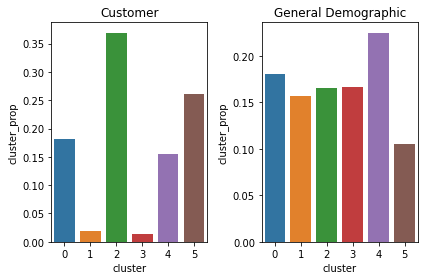

In [166]:
#Visualisation - seaborn
fig, ax =plt.subplots(1,2)
sns.barplot(x='cluster', y='cluster_prop', data=cust_cluster, ax=ax[0])
sns.barplot(x="cluster", y='cluster_prop', data=demo_cluster, ax=ax[1])

ax[0].set_title("Customer")
ax[1].set_title("General Demographic")

plt.tight_layout()
plt.show()

#Observations (after accounting for dropped cluster):
# 1) Cluster 2 still remained the overrepresented cluster, with cluster 5 coming up too.
# 2) Cluster 1 and 3 remained underrepresented still.

In [167]:
#from PCA interpretation
cols_of_interest = ['PLZ8_ANTG3','PLZ8_ANTG4','MOBI_REGIO',
                    'ALTERSKATEGORIE_GROB', 'SEMIO_ERL', 'SEMIO_REL', 'FINANZ_VORSORGER',
                    'ANREDE_KZ', 'SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_DOM', 'SEMIO_RAT' ]

In [178]:
#overrepresented (without accouting for dropped cluster)
pd.options.display.max_columns = 99
cluster_2 = final_df_customers.loc[final_df_customers_1.cluster == 2]
cluster_2.describe() #1: male, 2: females

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE,OST_WEST_KZ_O,OST_WEST_KZ_W
count,70571.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70105.000000,69233.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,67512.000000,70692.000000,69182.000000,69312.000000,70688.000000,70692.000000,67590.000000,67590.000000,67590.000000,67590.000000,67590.000000,70682.000000,70682.000000,70682.00000,70692.000000,64795.000000,67590.000000,69233.000000,64795.000000,70162.000000,69416.000000,69416.000000,69416.000000,69416.000000,69416.000000,69416.000000,70430.000000,70438.000000,70430.000000,70450.000000,70450.000000,70390.000000,70390.000000,70692.000000,70692.000000
mean,3.524139,1.005772,4.818395,1.333248,4.636295,1.366718,1.872871,2.077859,0.685962,1.936538,4.005936,4.881415,4.634739,3.724325,3.954337,6.254230,5.524204,3.935000,4.915266,2.643453,2.905647,3.249943,2.442709,2.999915,3.116746,0.009959,2.582456,0.026891,2.483195,3.990994,8.785223,1.696424,0.032938,3.364659,1993.167629,2.761858,1.168205,0.077068,0.012857,4.053825,4.455491,3.696061,5.00781,3.988075,2.229354,4.150362,3.247180,3.557234,703.237664,2.790639,2.600438,1.180074,0.377233,3.646436,3.863547,2.714312,4.837062,2.743376,2.840511,1.688318,2.119477,3.582711,0.044814,0.955186
std,0.660079,0.075751,0.468174,0.662058,0.730238,0.766562,0.917595,0.904795,0.464135,0.847180,1.102412,1.388701,1.316586,1.179697,2.137222,0.865672,1.599472,1.381815,0.939924,1.423447,1.192797,1.241130,0.959854,1.307207,1.338884,0.099296,1.403945,0.175604,1.356349,1.927699,0.898508,2.099422,0.185919,1.335387,3.172928,1.057050,0.929371,0.340180,0.127447,0.806183,1.986209,1.480525,1.79099,0.729086,0.992849,0.843551,1.191489,1.925450,346.053901,0.760590,0.740721,0.732363,0.505673,0.922491,0.875524,0.988415,1.972650,1.399893,1.283966,0.463184,1.201521,1.157453,0.206897,0.206897
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1985.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3.000000,1.000000,5.000000,1.000000,4.000000,1.000000,1.000000,2.000000,0.000000,1.000000,3.000000,3.000000,4.000000,3.000000,1.000000,6.000000,4.000000,3.000000,4.000000,1.000000,3.000000,3.000000,2.000000,2.000000,2.000000,0.000000,2.000000,0.000000,1.000000,2.000000,9.000000,1.000000,0.000000,2.000000,1992.000000,2.000000,0.000000,0.000000,0.000000,3.000000,3.000000,2.000000,4.00000,4.000000,1.000000,4.000000,2.000000,2.000000,462.000000,2.000000,2.000000,1.000000,0.000000,3.000000,3.000000,2.000000,3.000000,1.000000,2.000000,1.000000,1.00

In [169]:
#Question - for this, I cannot use the scaled and normalized version of the dataset to interpret, as the values will not make sense
#against the original encodings in the data dictionary. Is that right?

In [179]:
cluster_2.describe()[cols_of_interest]
#observation: Males (PC3), with low number of family homes with limited movement patters (PC1), Elderly not really a saver (PC2) 
#not dreamful, social, not family. Rather domineering and rational characters (PC3)

,PLZ8_ANTG3,PLZ8_ANTG4,MOBI_REGIO,ALTERSKATEGORIE_GROB,SEMIO_ERL,SEMIO_REL,FINANZ_VORSORGER,ANREDE_KZ,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_DOM,SEMIO_RAT
count,69416.000000,69416.000000,67590.000000,70571.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,1.180074,0.377233,4.150362,3.524139,3.935000,3.724325,4.636295,1.005772,6.254230,4.881415,4.634739,3.249943,2.643453
std,0.732363,0.505673,0.843551,0.660079,1.381815,1.179697,0.730238,0.075751,0.865672,1.388701,1.316586,1.241130,1.423447
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,0.000000,4.000000,3.000000,3.000000,3.000000,4.000000,1.000000,6.000000,3.000000,4.000000,3.000000,1.000000
50%,1.000000,0.000000,4.000000,4.000000,4.000000,4.000000,5.000000,1.000000,6.000000,6.000000,5.000000,3.000000,3.000000
75%,2.000000,1.000000,5.000000,4.000000,4.000000,4.000000,5.000000,1.000000,7.000000,6.000000,6.000000,5.000000,3.000000
max,3.000000,2.000000,6.000000,4.000000,7.000000,7.000000,5.000000,2.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [180]:
#underrepresented (without accounting for dropped cluster)
cluster_3 = final_df_customers.loc[final_df_customers_1.cluster == 3]
cluster_3.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFESTAGE,OST_WEST_KZ_O,OST_WEST_KZ_W
count,2761.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2504.000000,2706.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2527.000000,2784.000000,2779.000000,2780.000000,2784.000000,2784.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2784.000000,2784.000000,2784.000000,2784.000000,2680.000000,2691.000000,2706.000000,2680.000000,2741.000000,2707.000000,2707.000000,2707.000000,2707.000000,2707.000000,2707.000000,2775.000000,2775.000000,2775.000000,2598.000000,2598.000000,2772.000000,2772.000000,2784.000000,2784.000000
mean,1.871423,1.511853,1.984195,3.611351,2.650862,3.073276,3.298132,3.682471,0.138290,2.333866,3.223208,4.786638,5.070761,5.523348,4.721624,4.153017,3.318247,3.623563,5.158046,5.150144,4.362428,4.715158,4.537356,5.695761,4.935704,0.006106,1.646193,0.008980,5.156968,3.851998,7.528736,16.127024,0.139209,1.772629,1992.670259,0.357860,1.136009,1.072092,0.739502,2.058343,2.781609,5.514009,2.926724,3.131825,2.717910,1.716462,3.439024,4.929478,487.499818,1.336165,3.330994,2.548947,1.445142,3.782785,2.465460,3.515315,7.470991,3.772613,5.157429,1.148191,4.190476,2.165584,0.257543,0.742457
std,0.792024,0.499949,0.899815,1.263587,1.233244,1.328135,1.393036,1.088156,0.345266,0.710317,1.340563,2.048045,1.719983,1.451638,1.680697,2.113116,1.941845,1.772093,1.710072,1.557526,1.897036,2.076261,2.077385,1.342164,1.583636,0.077918,1.149685,0.098087,0.898836,1.831873,2.038940,24.508503,0.800127,1.033933,2.569571,0.639581,1.425761,1.163576,0.819464,1.026026,2.268313,0.873915,1.717682,0.896478,0.852448,0.834360,1.329105,1.793322,245.476621,0.574813,0.892075,0.589469,0.599521,0.924792,0.926636,0.668883,1.514103,1.033247,1.153023,0.355358,0.902186,1.560404,0.437360,0.437360
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1985.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,23.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,2.000000,2.000000,2.000000,3.000000,0.000000,2.000000,2.000000,3.000000,4.000000,4.000000,3.000000,2.000000,2.000000,2.000000,4.000000,4.000000,3.000000,3.000000,2.000000,5.000000,4.000000,0.000000,1.000000,0.000000,5.000000,2.000000,6.000000,7.000000,0.000000,1.000000,1992.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,2.000000,3.000000,2.000000,1.000000,3.000000,3.000000,315.000000,1.000000,3.000000,2.000000,1.000000,3.000000,2.000000,3.000000,7.000000,3.000000,5.000000,1.000000,4.000000,1.000000,0.000000,0.000000
50%,2.000000,2.000000,2.

In [181]:
cluster_3.describe()[cols_of_interest]
#observation: less of gender, but more of age (30-45 years old), with high number of homes and high mobility patterns (PC1 and 2).
#not religious, low financial interest, not social and family oriented. Also not dominant and rational (PC3)

,PLZ8_ANTG3,PLZ8_ANTG4,MOBI_REGIO,ALTERSKATEGORIE_GROB,SEMIO_ERL,SEMIO_REL,FINANZ_VORSORGER,ANREDE_KZ,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_DOM,SEMIO_RAT
count,2707.000000,2707.000000,2691.000000,2761.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000,2784.000000
mean,2.548947,1.445142,1.716462,1.871423,3.623563,5.523348,2.650862,1.511853,4.153017,4.786638,5.070761,4.715158,5.150144
std,0.589469,0.599521,0.834360,0.792024,1.772093,1.451638,1.233244,0.499949,2.113116,2.048045,1.719983,2.076261,1.557526
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,4.000000,2.000000,1.000000,2.000000,3.000000,4.000000,3.000000,4.000000
50%,3.000000,2.000000,1.000000,2.000000,4.000000,6.000000,2.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5.000000
75%,3.000000,2.000000,2.000000,2.000000,5.000000,7.000000,4.000000,2.000000,6.000000,7.000000,7.000000,7.000000,7.000000
max,3.000000,2.000000,6.000000,4.000000,7.000000,7.000000,5.000000,2.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [173]:
#need to see cluster_5 features

In [174]:
#Cluster 5 in customers: overepresented
second_dataset_customers.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,50005.000000,50012.000000,49900.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,49900.000000,50012.000000,3341.000000,8721.000000,8728.000000,8756.000000,8756.000000,49900.000000,49900.000000,3348.000000,2808.000000,49900.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,3341.000000,3416.000000,3341.000000,50012.000000,3416.000000,3416.000000,47044.000000,961.000000,3416.000000,58.000000,58.000000,85.000000,3367.000000,85.000000,85.000000,2.0,2.000000,2.0,2.0,2.000000,85.000000,85.000000,85.000000,85.000000,30.000000,2.000000,49900.000000,30.000000,26.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.000000,84.000000,84.000000
mean,1.826717,1.506039,5.477415,3.113573,3.829501,3.107494,4.812405,4.857914,2.930117,3.897865,5.311804,0.000180,1.575875,25.532049,7.704170,6.234696,3.378598,5.308517,2.244950,1.045699,5.027422,3.158216,2.082300,5.886547,6.732324,5.004219,1.327741,4.941074,3.097397,3.028233,3.950432,6.826382,5.852755,5.855795,4.937575,2.953731,2.203831,0.011124,1.090691,3.042730,2.177986,0.021370,2.003720,1.839750,8.533372,8.241379,0.017241,2.023529,2.768637,2007.094118,2.729412,2.0,1.500000,0.0,0.0,4.500000,4.352941,3.705882,4.752941,3.752941,2.600000,3.500000,2.181523,4.566667,775.653846,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.714286,4.857143,2.571429
std,0.899647,0.499969,1.295276,0.450126,0.670764,0.450064,0.765422,0.562758,0.323716,0.466131,1.502796,0.013414,0.715110,12.249674,4.032186,4.303143,1.753578,1.591094,0.817882,0.264416,3.361112,0.599202,0.399137,0.744045,1.056725,0.382113,1.283954,0.409182,0.576419,0.450686,0.498024,0.858969,0.702200,0.742831,0.243329,0.451192,0.927651,0.104898,0.287213,0.358225,1.368307,0.150587,0.087034,0.849829,1.327951,8.253251,0.131306,1.668878,1.363165,7.549241,2.740300,0.0,0.707107,0.0,0.0,0.707107,2.021938,1.564666,1.724514,0.924609,0.932183,0.707107,0.681596,1.906130,366.199393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000860,2.060196,1.546747
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1985.000000,0.000000,2.0,1.000000,0.0,0.0,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,150.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000
25%,1.000000,1.000000,6.000000,3.000000,4.000000,3.000000,5.000000,5.000000,3.000000,4.000000,5.000000,0.000000,1.000000,14.000000,4.000000,2.000000,2.000000,5.000000,2.000000,1.000000,3.000000,3.000000,2.000000,6.000000,7.000000,5.000000,1.000000,5.000000,3.000000,3.000000,4.000000,7.000000,6.000000,6.000000

In [175]:
second_dataset_customers.describe()[cols_of_interest]
#Observation:
#1) Mixed of males and females
#2) 30-45 years old, low reliogiosity, low family-oriented personaility, not domineering, highly social highly dreamful 

#Conclusion: Perhaps most dependable feature could be age group, and personality (low on reliogisity and family).

,PLZ8_ANTG3,PLZ8_ANTG4,MOBI_REGIO,ALTERSKATEGORIE_GROB,SEMIO_ERL,SEMIO_REL,FINANZ_VORSORGER,ANREDE_KZ,SEMIO_VERT,SEMIO_SOZ,SEMIO_FAM,SEMIO_DOM,SEMIO_RAT
count,0.0,0.0,2.000000,50005.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000,50012.000000
mean,NaN,NaN,3.500000,1.826717,3.097397,6.732324,3.107494,1.506039,1.327741,2.082300,5.886547,5.852755,3.950432
std,NaN,NaN,0.707107,0.899647,0.576419,1.056725,0.450064,0.499969,1.283954,0.399137,0.744045,0.702200,0.498024
min,NaN,NaN,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000
25%,NaN,NaN,3.250000,1.000000,3.000000,7.000000,3.000000,1.000000,1.000000,2.000000,6.000000,6.000000,4.000000
50%,NaN,NaN,3.500000,2.000000,3.000000,7.000000,3.000000,2.000000,1.000000,2.000000,6.000000,6.000000,4.000000
75%,NaN,NaN,3.750000,3.000000,3.000000,7.000000,3.000000,2.000000,1.000000,2.000000,6.000000,6.000000,4.000000
max,NaN,NaN,4.000000,4.000000,7.000000,7.000000,5.000000,2.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [176]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#Ans: Elderly Males, do not have high mobility and owns small number of family homes.
#They score high in DOM, KAEM, KRIT (usual male traits) as per PC3.

#Accounting for the dropped cluster earlier, the info on the cluster seems inconclusive, although it is likely that the age group
#of 30-45 could be a tenable segment (regardless of gender).

In [177]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#Ans: 30-45 years old with high mobility and high number of family homes. Low financial interest per PC2.

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Ans: A popular cluster for the mail-order company would be elderly gentlemen. The personaility traits are also key features as they are inextricably linked to gender (from PCA analysis earlier). In conclusion, males have more domineering, rational, critical or combative personalities. Those that are not popular with the company could be middle age group individuals with high number of family homes and low financial interest (likes to spend and not save).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.